In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from fastai import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.tabular import *
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset

torch.cuda.is_available()

True

### Load ksent vectors of random genome samples of 16kb

In [ ]:
df = pd.read_pickle("../data/random-ksent.pkl")

#### Look at the data

In [2]:
df.head()

,spicies,ksent
0,subtilis,"[-0.14380797743797302, 0.042256396263837814, 0..."
1,subtilis,"[-0.05331391096115112, 0.06979767978191376, 0...."
2,velezensis,"[-0.0810142382979393, 0.0927421897649765, 0.15..."
3,velezensis,"[-0.11013756692409515, 0.08658633381128311, 0...."
4,anthracis,"[-0.01958618313074112, 0.11950772255659103, 0...."


In [19]:
df.shape

(690000, 2)

In [18]:
df.spicies.value_counts()

subtilis      321000
velezensis    216000
anthracis     153000
Name: spicies, dtype: int64

###  Databunch

In [3]:
valid_idx = random.sample(range(df.shape[0]), int(np.floor(df.shape[0]* 0.2)))

db = (ItemList.from_df(df,cols="ksent").
      split_by_idx(valid_idx).
      label_from_df(cols="spicies").
      databunch())

###  Model

In [4]:
def submodel(dims, bias=False):
    layer_dims = list(zip(dims[:-1],dims[1:]))
    fcl = [nn.Linear(*x, bias=bias) for x in layer_dims]
    [nn.init.xavier_uniform_(m.weight) for m in fcl]
    if bias: 
        for l in fcl: l.bias.data.normal_(0, 1)
    relu = [nn.ReLU() for _ in range(len(fcl))]
    layers = np.asarray(list(zip(fcl, relu))).ravel()[:-1]
    return nn.Sequential(*layers)


In [5]:
class Classifier (nn.Module):

    def __init__(self, encoder_dims, classifier_dims):
        super().__init__()
        self.encoder = submodel(encoder_dims,bias=True)
        self.classifier = submodel(classifier_dims,bias=True)


    def forward(self, x):
        x = self.encoder(x)
        return F.softmax(self.classifier(x), dim=1)

    def save_encoder(self,file:PathOrStr):
        torch.save(self.encoder.state_dict(), path)


In [8]:
model = Classifier([100,50,3], [3,20,3]).double()

In [9]:
model

Classifier(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=3, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=3, bias=True)
  )
)

### Learner

In [12]:
learn = Learner(db, model,metrics=[accuracy])
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


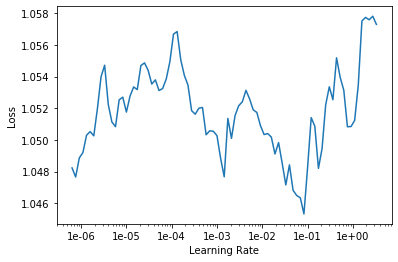

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.588498,0.583153,0.968529,00:35
1,0.593730,0.606674,0.943275,00:35
2,0.594737,0.589081,0.962116,00:35
3,0.600526,0.583841,0.967457,00:36
4,0.591394,0.605085,0.945500,00:35
5,0.586290,0.582825,0.968377,00:36
6,0.584365,0.580657,0.970710,00:36
7,0.586121,0.583098,0.968109,00:35
8,0.580480,0.580342,0.970928,00:36
9,0.578384,0.579312,0.972043,00:37


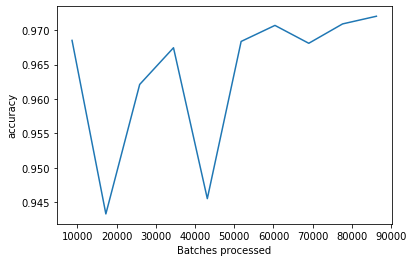

In [16]:
learn.recorder.plot_metrics()

In [17]:
interpretation = learn.interpret()

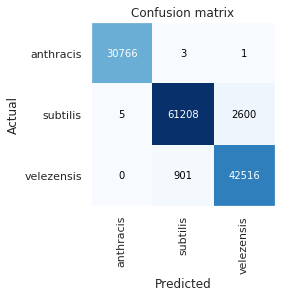

In [30]:
interpretation.plot_confusion_matrix()